In [7]:
import os
import subprocess
from copy import copy, deepcopy

# ASE and i-PI scripting utilities
import ase.units
import chemiscope
import matplotlib.pyplot as plt

# pet-mad ASE calculator
import metatensor.torch.atomistic as mta
import numpy as np
import requests
from ase.optimize import LBFGS
from ipi.utils.mathtools import get_rotation_quadrature_lebedev
from ipi.utils.parsing import read_output, read_trajectory
from ipi.utils.scripting import (
    InteractiveSimulation,
    forcefield_xml,
    motion_nvt_xml,
    simulation_xml,
)
from pet_mad.calculator import PETMADCalculator


if hasattr(__import__("builtins"), "get_ipython"):
    get_ipython().run_line_magic("matplotlib", "inline")  # noqa: F821

In [8]:
from metatensor.torch.atomistic.ase_calculator import MetatensorCalculator
calculator = MetatensorCalculator("model_250.pt", extensions_directory="extensions/")


In [18]:
filename = "/home/forina/Documents/MIT/MIT_Training/ScatterPlot/dataset_silica_water_NNIP.xyz"
if not os.path.exists(filename):
    url = (
        "https://huggingface.co/lab-cosmo/pet-mad/resolve/"
        "main/benchmarks/mad-test-mad-settings.xyz"
    )
    response = requests.get(url)
    response.raise_for_status()
    with open(filename, "wb") as f:
        f.write(response.content)

test_structures = ase.io.read(filename, "::100")

# also extract reference energetics and metadata
test_energy = []
test_forces = []
test_natoms = []
test_origin = []
subsets = []

for s in test_structures:
    test_energy.append(s.get_potential_energy())
    test_natoms.append(len(s))
    test_forces.append(s.get_forces())
    #test_origin.append(s.info["origin"])
    #if s.info["origin"] not in subsets:
    #    subsets.append(s.info["origin"])

test_natoms = np.array(test_natoms)
#test_origin = np.array(test_origin)
test_energy = np.array(test_energy)
test_forces = np.array(test_forces, dtype=object)

In [19]:
mad_energy = []
mad_forces = []
mad_structures = []
for structure in test_structures:
    tmp = deepcopy(structure)
    tmp.calc = copy(calculator)  # avoids ovewriting results.
    mad_energy.append(tmp.get_potential_energy())
    mad_forces.append(tmp.get_forces())
    mad_structures.append(tmp)

mad_energy = np.array(mad_energy)
mad_forces = np.array(mad_forces, dtype=object)

In [13]:
mad_forces,mad_energy

(array([array([[ 0.00192005,  0.12161747,  0.00053777],
               [ 0.17163923, -0.06426414, -0.00014837],
               [-0.17355928, -0.05735335, -0.0003894 ]]), array([[-0.06964236,  1.05437219,  0.47424868],
                                                                 [-0.01939186, -0.13195805, -0.19456589],
                                                                 [ 0.49990183,  0.5766452 , -0.89907449],
                                                                 [ 0.3073284 ,  0.4828214 ,  0.97215933],
                                                                 [-0.66678345, -0.09370089,  1.03705299],
                                                                 [ 0.08033024, -0.01322062, -0.09159333],
                                                                 [-1.04603028,  0.2213331 , -0.50368965],
                                                                 [-0.95641041, -0.54424661,  0.05926469],
                                        

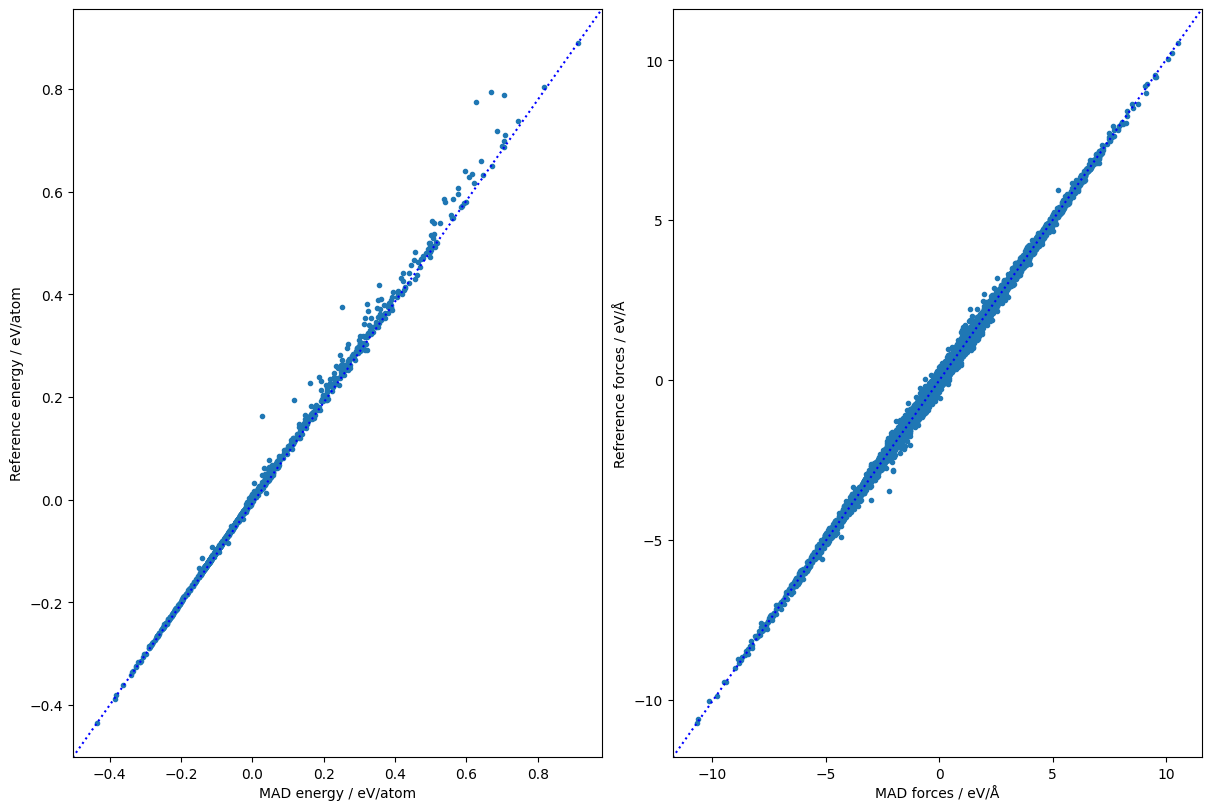

In [23]:
tab10 = plt.get_cmap("tab10")
fig, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

ax[0].plot(
        mad_energy / test_natoms,
        test_energy / test_natoms,
        ".",
    )
ax[1].plot(
    np.concatenate(mad_forces).flatten(),
    np.concatenate(test_forces).flatten(),
    ".",
    )

ax[0].plot([0, 1], [0, 1], "b:", transform=ax[0].transAxes)
ax[1].plot([0, 1], [0, 1], "b:", transform=ax[1].transAxes)

# for i, sub in enumerate(subsets):
#     sel = np.where(test_origin == sub)[0]
#     ax[0].plot(
#         mad_energy[sel] / test_natoms[sel],
#         test_energy[sel] / test_natoms[sel],
#         ".",
#         c=tab10(i),
#         label=sub,
#     )
#     ax[1].plot(
#         np.concatenate(mad_forces[sel]).flatten(),
#         np.concatenate(test_forces[sel]).flatten(),
#         ".",
#         c=tab10(i),
#     )

ax[0].set_xlabel("MAD energy / eV/atom")
ax[0].set_ylabel("Reference energy / eV/atom")
ax[1].set_xlabel("MAD forces / eV/Å")
ax[1].set_ylabel("Refrerence forces / eV/Å")

#fig.legend(loc="upper center", bbox_to_anchor=(0.55, 1.20), ncol=3)
# Save the figure
fig.savefig("PET_vs_reference.png", dpi=300, bbox_inches='tight')